### Importeren van de libraries

In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [16]:
lr = LinearRegression()

In [17]:
# functie om seizoenen toe te voegen aan dataframe
def add_season(huis):
    huis['winter'] = 0
    huis['lente'] = 0
    huis['zomer'] = 0
    huis['herfst'] = 0
    i = 0
    while i < 366:
        if i < 80:
            huis.iloc[i, 9] = 1
        elif i >= 80 and i < 173:
            huis.iloc[i, 10] = 1
        elif i >= 173 and i < 267:
            huis.iloc[i, 11] = 1
        elif i >= 267 and i < 355:
            huis.iloc[i, 12] = 1
        else: 
            huis.iloc[i, 9] = 1
        i += 1
    return huis 

In [18]:
# functie om de ouliers te verwijderen op basis van het gemiddelde en de standaarddeviaties per seizoen
def verwijder_outlier(huis):
    
    huis = huis[:-2]
    mean = np.mean(huis.iloc[:, 7])
    std = np.std(huis.iloc[:, 7])
    
    for i in range(len(huis)):
        
        if i >= 355 or i < 80:
            mean = np.mean(huis.loc[huis['winter'] == 1, 'perdag_verbruik'])
            std = np.std(huis.loc[huis['winter'] == 1, 'perdag_verbruik'])
        elif i >= 80 or i < 173:
            mean = np.mean(huis.loc[huis['lente'] == 1, 'perdag_verbruik'])
            std = np.std(huis.loc[huis['lente'] == 1, 'perdag_verbruik'])
        elif i >= 173 or i < 267:
            mean = np.mean(huis.loc[huis['zomer'] == 1, 'perdag_verbruik'])
            std = np.std(huis.loc[huis['zomer'] == 1, 'perdag_verbruik'])
        elif i >= 173 or i < 267:
            mean = np.mean(huis.loc[huis['herfst'] == 1, 'perdag_verbruik'])
            std = np.std(huis.loc[huis['herfst'] == 1, 'perdag_verbruik'])
            
        if huis.iloc[i, 7] > mean + 3 * std or huis.iloc[i, 7] < mean - 3 * std:
            huis.iloc[i, 7] = huis.iloc[i-1, 7] 

    return huis

In [19]:
# functie om een dag te voorspellen met een opgegeven periode en het huishouden
def voorspel_per_dag(begin_dag, voorspel_dag, huis_dag):
    if voorspel_dag > 363:
        voorspel_dag = 363
    huis_dag['range'] = range(366)
    
    huis_dag_met_seizoen = add_season(huis_dag)
    
    verwijder_outlier(huis_dag_met_seizoen)
 
    X_train = huis_dag_met_seizoen.iloc[begin_dag:voorspel_dag, 8:13].values
    y_train = huis_dag_met_seizoen.iloc[begin_dag:voorspel_dag, 7].values
    poly_model = PolynomialFeatures(degree = 3)
    poly_X = poly_model.fit_transform(X_train)
    poly_model.fit(poly_X, y_train)

    lr.fit(poly_X, y_train)

    X_test = [huis_dag_met_seizoen.iloc[voorspel_dag, 8:13]]
    y_test = huis_dag_met_seizoen.iloc[voorspel_dag, 7]
    poly_X = poly_model.fit_transform(X_test)

    multi_poly_pred = lr.predict(poly_X)

    return y_test, multi_poly_pred[0]

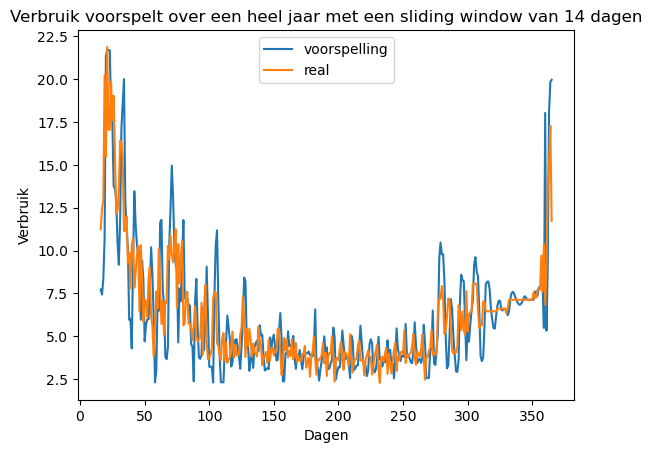

In [20]:
# Hier wordt er voor elke dag van het jaar(behalve de eerste 14 dagen) een voorspelling gemaakt met een sliding window van 14 dagen 
r2_list = []
lijst = [26]
for i in lijst:
    df = "df0" + str(i) + "_perdag"
    huis = pd.read_csv(df, index_col=0)
    voorspelling = []
    real = []
    for i,j in zip(range(351),range(14, 364)):
        uitkomst = voorspel_per_dag(i, j , huis)
        voorspelling.append(uitkomst[1])
        real.append(uitkomst[0])
    for i in voorspelling: # Hier worden onrealistische pieken vervangen door een voorpelling van de vorige dag
         if i > max(real) or i < min(real):
            voorspelling[voorspelling.index(i)] = voorspelling[voorspelling.index(i)-1] 
    combi = df, r2_score(voorspelling, real)
    plt.plot(huis['range'][16:], voorspelling, label = 'voorspelling')
    plt.plot(huis['range'][16:], real, label = 'real')
    plt.xlabel('Dagen')
    plt.ylabel('Verbruik')
    plt.title('Verbruik voorspelt over een heel jaar met een sliding window van 14 dagen')
    plt.legend()
    plt.show()
    r2_list.append(combi)

In [22]:
r2_list

[('df026_perdag', 0.6195777580258925)]